## WARNING !
All the questionable decisions i have marked with comment #TODO
to think about them and discuss.


In [92]:
#Mine - Synthetic

In [93]:
import itertools
import datetime
import pickle
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pylab
import cvxpy as cp
from scipy.linalg import eigh
from collections import OrderedDict
import pandas as pd
import scipy as sp
import seaborn as sns
import scipy.stats as stats
import random
import argparse
from time import time
import os
#from google.colab import files
from scipy.sparse import coo_matrix
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
np.random.seed(42)

## Parameters of experiment

In [95]:
nodes = 10#int(input(" NODES in the graph : "  )) #number of arms
super_arm_sparsity = 4 #int(input(" number of chosen arms in the super arm is : "  )) #number of chosen arms
rounds = 4300 #int(input(" rounds of observation (decision making) : "  )) # number of rounds of data we create

In [96]:
#change points
change_points = [0, 300, 700, 1000, 1300, 1600, 2000, 2500, 2800, 3200, 3600, 4000]

In [97]:
# Reasonable parameters I have found xi = 1 * 1e-7, gamma = 0.87

In [98]:
# xi = 1e-7 # larger -> more exploration
s = super_arm_sparsity
# gamma = 0.87 # smaller -> more forgetting / more exploration

In [99]:
Delay = 50 #10
skiped = 0
best_lambda = 0.1

## Useful functions


### Create graph

In [100]:
def create_graph(n):
    
    # This value is chosen so that resulting density of DAG is 0.15
    prob_of_edge = 0.25 #float(input("* Please enter the probability of having an edge in your random graph:"  ))
    G = nx.gnp_random_graph(n=n, p=prob_of_edge, directed=True, seed=6)
    
    # Make the graph directed and acyclic
#     DAG = nx.DiGraph([(u, v, {'weight': np.random.uniform(low=0.9, high=0.95)}) for (u, v) in G.edges() if u < v])
    DAG = nx.DiGraph([(u, v) for (u, v) in G.edges() if u < v])
    print('* Is the graph a DAG? ', nx.is_directed_acyclic_graph(DAG))
    
    # building the adjacency numpy matrix of the graph
    edge_list = list(DAG.edges())
    number_of_edges = len(edge_list)
    
    w = np.zeros((n, n)) # the numpy adjacency matrix with all edge weights equal to 1    
    for edge in edge_list:
        w[edge[0], edge[1]] = np.random.uniform(low=0.4, high=0.7)
    
    if np.count_nonzero(w) == number_of_edges:
        print('The adjacency matrix is correctly set as a randomly picked DAG!')
        
    temp1 = np.eye(w.shape[0]) - w
    C = np.linalg.inv(temp1)
    C_axis_0_sum = np.sum(C, axis=0)
    
    print('the elements of the vector C are:  ', np.transpose(C_axis_0_sum))
    return w , C

In [101]:
def change_point_index(time_point):
    """Return index of last happened change point by the time `time_point`"""
    global change_points
    global rounds
    assert time_point >= change_points[0], f"Time point smaller than first change point {change_points[0]}"
    assert time_point <= rounds, f"Time point larger than total num of rounds {rounds}"
    
    for ind, ch_p in enumerate(change_points):
        if time_point < ch_p:
            return ind - 1
    else:
        return len(change_points) - 1

### Rewards

In [102]:
def instantaneous_Bernoulli_rewards(high_interval, low_interval):
    mean_b_gt_Bern = np.zeros((len(change_points), nodes, 1))
    B = np.zeros((nodes, rounds))
    

    for i in range(0, len(change_points)):
        # For s nodes chose mean values higher than for others.
        high_reward_nodes = [(ind + i*s) % nodes for ind in range(s)]
        
        print(high_reward_nodes)
        low_reward_nodes = np.array([i for i in range(nodes) if i not in high_reward_nodes])
        
        # Chose means uniformly at random
        mean_b_gt_Bern[i, high_reward_nodes, :] = np.random.uniform(
            low=high_interval[0], high=high_interval[1], size=(len(high_reward_nodes), 1)
        ) 
        
        
        mean_b_gt_Bern[i, low_reward_nodes, :] = np.random.uniform(
            low=low_interval[0], high=low_interval[1], size=(len(low_reward_nodes), 1)
        )
        
        # Make sure one of the base arms almost reaches high and low ends.
        mean_b_gt_Bern[
            i, np.random.choice(high_reward_nodes), :
        ] = high_interval[1] - np.random.normal(scale=(high_interval[1] - high_interval[0])/20)
        
        mean_b_gt_Bern[
            i, np.random.choice(low_reward_nodes), :
        ] = low_interval[0] + np.random.normal(scale=(low_interval[1] - low_interval[0])/20)
        
    for j in range(rounds):
        ch_p_ind = change_point_index(j)
        for k in range(nodes):
            B[k, j] = np.random.binomial(n=1, p=mean_b_gt_Bern[ch_p_ind, k])
    
    return B, mean_b_gt_Bern;
	
#   function to create the random action X

def rand_binary_array(number_of_chosen_arms=super_arm_sparsity, n=nodes): 
    
    arr = np.zeros((n,1))
    arr[:(number_of_chosen_arms)] = 1
    np.random.shuffle(arr)
    return arr

def create_random_action(number_of_chosen_arms=super_arm_sparsity, n=rounds):

    X = rand_binary_array(number_of_chosen_arms=number_of_chosen_arms)
    for i in range(n-1):
        temp2 = rand_binary_array(number_of_chosen_arms=number_of_chosen_arms)
        X = np.concatenate((X,temp2),axis=1)
    return X
	
def f_measure_func(x, xgt): #Not read yet
    
    x=np.where(x!=0,1,0)
    xgt=np.where(xgt!=0,1,0)
    true_pos = np.count_nonzero(np.multiply(x,xgt))
    fals_pos = np.count_nonzero(np.where((x-xgt)>0,1,0))
    fals_neg = np.count_nonzero(np.where((xgt-x)>0,1,0))
    true_neg = nodes**2 - true_pos - fals_neg - fals_pos
    f_measure=true_pos/(true_pos+0.5*(fals_neg+fals_pos))
    
    return f_measure

### Graph learning

In [103]:
#................................SEM + L1 graph learning
#TODO check real world and that A is not negative
def graph_learning(
    current_time, A_gt, observ, perturb, nodes = nodes, skiped=skiped, best_lambda=best_lambda, Delay=Delay
):

    if skiped == 0: 
        lambda_params = np.array([0.00001,0.0001,0.001,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10\
                          ,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9\
                          ,10,20,30,40,50,60,70,80,90,100,1000,10000,100000,1000000])
    elif skiped == 1:
        lambda_params = np.asarray([best_lambda])
    
    # If no current time < Delay then agent has no observations yet. 
    # Must be > 0 because otherwise indexing works wrong, starts from the end.
    time_up_to_delay = max(0, current_time - Delay)
    observ = observ[:,:time_up_to_delay] #!
    perturb = perturb[:,:time_up_to_delay] #!

    error_SEM_L1 = np.ones([lambda_params.shape[0],1])*10000000000000000000
    for k in range (lambda_params.shape[0]):
        A        = cp.Variable((nodes,nodes))
        #TODO When no observations - just minimize the regularizer term.
        cost     = (
            cp.sum_squares(observ - (A @ observ) - perturb) + lambda_params[k] * cp.atoms.norm1(A) 
            if time_up_to_delay > 0 
            else lambda_params[k]*cp.atoms.norm1(A) 
        )
        obj      = cp.Minimize(cost)
        constr   = [cp.diag(A) ==0 , A[:,:] >= 0]
        prob     = cp.Problem(obj,constr)
        opt_val  = prob.solve()
        solution_L1Norm = A.value

        error_SEM_L1[k] = np.sum(np.power((A_gt - A.value),2)) / (nodes*nodes) 
    
        if error_SEM_L1[k] <= np.amin(error_SEM_L1):
            The_final_solution_SEM_L1 = A.value
            solution_threshold_SEM_L1 = np.where(np.absolute(A.value)<\
                                             (0.1*np.amax(np.absolute(A.value))),0,A.value)
#             solution_Boolean_SEM_L1 = np.where(solution_threshold_SEM_L1==0,0,1)
            best_lambda = lambda_params[k]
#             optvalue1 = opt_val

    f_measure = f_measure_func(solution_threshold_SEM_L1, A_gt)
#     print('the f-measure is : ', f_measure)
        
    return The_final_solution_SEM_L1, f_measure, best_lambda

In [104]:

# Finding solution new function

def Best_action_func_new(A, b, s = super_arm_sparsity):
#A --> Estimated A or w_gt
#b --> UCB or mean_b_gt[i,:]
    
    temp_inv        = np.linalg.inv(np.eye(nodes) - A)
    b_diag          = np.diagflat(b) 
    C               = np.matmul(temp_inv, b_diag)
#     print("C.shape is", C.shape)
    C_axis_0_sum    = np.sum(C,axis=0) 
#     print("C_axis_0_sum.shape is", C_axis_0_sum.shape)
    ind             = np.argsort(C_axis_0_sum,axis=0)[-s:]
    x               = np.zeros((nodes,1))
    for i in range(ind.shape[0]):
        x[ind[i],0] = 1
        
    if (b == b[0]).all():
            np.random.shuffle(x)
    
    return x


### UCB func


In [105]:

# UCB  function as part of decision making strategy

# def UCB_func(t, x, T, b_bar, b_hat, b):
def UCB_func(t, x, num_plays_state, inst_reward, xi, s, gamma, Delay):
    
    emp_avg_reward_state_builtin = np.zeros((num_plays_state.shape[0], 1))
    UCB_state_builtin = np.ones((num_plays_state.shape[0], 1))
    
    m_t_gamma = sum([gamma ** (t - tau) for tau in range(1, t + 1)])
    
    delayed_discounted_counts_state = np.zeros(num_plays_state.shape[0])
    for k in range(num_plays_state.shape[0]):
        for j in range(t - Delay):
            delayed_discounted_counts_state[k] += num_plays_state[k,:,j]*(gamma**(t-j))


    emp_avg_reward_state_temp = np.zeros(num_plays_state.shape[0])
    for k in range(num_plays_state.shape[0]):
        for j in range(t-Delay):
            emp_avg_reward_state_temp[k] = emp_avg_reward_state_temp[k] + inst_reward[k,j]*num_plays_state[k,:,j]*(gamma**(t-j))

    array_indices_of_chosen_base_arms = np.where(x!=0)
    for i in range(array_indices_of_chosen_base_arms[0].shape[0]):
        j = array_indices_of_chosen_base_arms[0][i]
        
        if delayed_discounted_counts_state[j] != 0 and t >= Delay:
            emp_avg_reward_state_builtin[j,0] = emp_avg_reward_state_temp[j] / (delayed_discounted_counts_state[j])
            
            inside_sqrt = (xi * s * np.log(m_t_gamma)) / (delayed_discounted_counts_state[j]) 
            if inside_sqrt < 0:
                raise ValueError('UCB calculation produced nan value, because inside sqrt is ', inside_sqrt)

            UCB_state_temp = emp_avg_reward_state_builtin[j, 0] + np.sqrt(inside_sqrt) # UCB calculations for the chosen arms
            UCB_state_builtin[j, 0] = UCB_state_temp
            # print((xi *s*np.log(t+1)) / (delayed_discounted_counts_state[j]))
        else:
            pass
#             print("The given base arm is not pulled yet")
#             print("Its UCB is:", UCB_state_builtin[j,0])
#             print(delayed_discounted_counts_state[j])
    
    array_indices_of_not_chosen_base_arms = np.where(x==0)
    for i in range(array_indices_of_not_chosen_base_arms[0].shape[0]):
        k = array_indices_of_not_chosen_base_arms[0][i]
        
        if delayed_discounted_counts_state[k] != 0 and t >= Delay:
            #TODO Added this line, why did it work without it?
            # Without this line for all not-chosen arms had empirical reward zero
            emp_avg_reward_state_builtin[k,0] = emp_avg_reward_state_temp[k] / (delayed_discounted_counts_state[k])
            
            inside_sqrt = (xi * s * np.log(m_t_gamma)) / (delayed_discounted_counts_state[k]) 
            if inside_sqrt < 0:
                raise ValueError('UCB calculation produced nan value, because inside sqrt is ', inside_sqrt)
            UCB_state_temp = emp_avg_reward_state_builtin[k,0] + np.sqrt(inside_sqrt) # UCB calculations for the non-chosen arms 
            UCB_state_builtin[k,0] = UCB_state_temp
    #         print((xi*s*np.log(t+1))) # / (delayed_discounted_counts_state[k])
    #         print(delayed_discounted_counts_state[k])
        else:
            pass
#             print("The given (not selected) base arm is not pulled yet")
#             print("Its UCB is:", UCB_state_builtin[k,0])
#             print(delayed_discounted_counts_state[k])
            
    new_num_plays_state = (np.asanyarray([x])).T.astype(int) #(num_plays_state[:,:,] + )

    return new_num_plays_state, emp_avg_reward_state_builtin, UCB_state_builtin



In [106]:

def overall_reward(x, b, A):
#b --> mean_b_gt[i,:]
#A --> w_gt
    assert x.shape == (nodes, 1), f"Shape is {x.shape}"
    assert b.shape == x.shape, f"Shape of b {b.shape} must be same as x.shape={x.shape}"
    temp_inv = np.linalg.inv(np.eye(nodes) - A)
    temp_multiply = np.multiply(b, x)
    temp = np.matmul(temp_inv, temp_multiply)
    rew = np.sum(temp)
    
    return rew

## Create ground truth rewards and graph, set parameters

In [107]:
# Parameters of the experiment

# create the graph and the B
w_gt, C_gt = create_graph(n=nodes); # create the gt graph
# B, mean_b_gt = instantaneous_Gaussian_rewards(maxx=0.7, minn=0.3); # create the gt 'b'
# B, mean_b_gt = instantaneous_Gaussian_rewards_with_gap(maxx=0.7, minn=0.3);
B, mean_b_gt = instantaneous_Bernoulli_rewards(high_interval=[0.75, 0.9], low_interval=[0.1, 0.3]);


* Is the graph a DAG?  True
The adjacency matrix is correctly set as a randomly picked DAG!
the elements of the vector C are:   [1.         1.         1.         1.         1.         1.51236204
 1.         1.57959755 4.46831448 1.41742508]
[0, 1, 2, 3]
[4, 5, 6, 7]
[8, 9, 0, 1]
[2, 3, 4, 5]
[6, 7, 8, 9]
[0, 1, 2, 3]
[4, 5, 6, 7]
[8, 9, 0, 1]
[2, 3, 4, 5]
[6, 7, 8, 9]
[0, 1, 2, 3]
[4, 5, 6, 7]


/tmp/ls131416/login23-g-1_124632/ipykernel_125043/2363986547.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[k, j] = np.random.binomial(n=1, p=mean_b_gt_Bern[ch_p_ind, k])


In [108]:
#TODO Oracle should see t or (t-Delay) data points?

# calculate the best action for the given graph and 'b'
best_action_choice = np.zeros((len(change_points), nodes, 1))
for i in range(len(change_points)):
    best_action_choice[i,:,:] = Best_action_func_new(A=w_gt, b=mean_b_gt[i, :], s=super_arm_sparsity)

# calculate the best reward for the best action so that later use it in regret calculation
best_expected_reward = np.zeros(len(change_points))
for i in range(len(change_points)):
    best_expected_reward[i] = overall_reward(x=best_action_choice[i,:], b=mean_b_gt[i,:], A=w_gt)

print('the best overall reward is ', best_expected_reward)
print('Density of the ground truth graph is: ',(np.count_nonzero(w_gt))/((nodes*nodes)-nodes))


the best overall reward is  [3.5048015  4.67886735 6.53547161 3.81096602 7.29653535 3.28808367
 4.28574341 6.78029342 3.95214181 7.29408798 3.46086615 4.46457371]
Density of the ground truth graph is:  0.08888888888888889


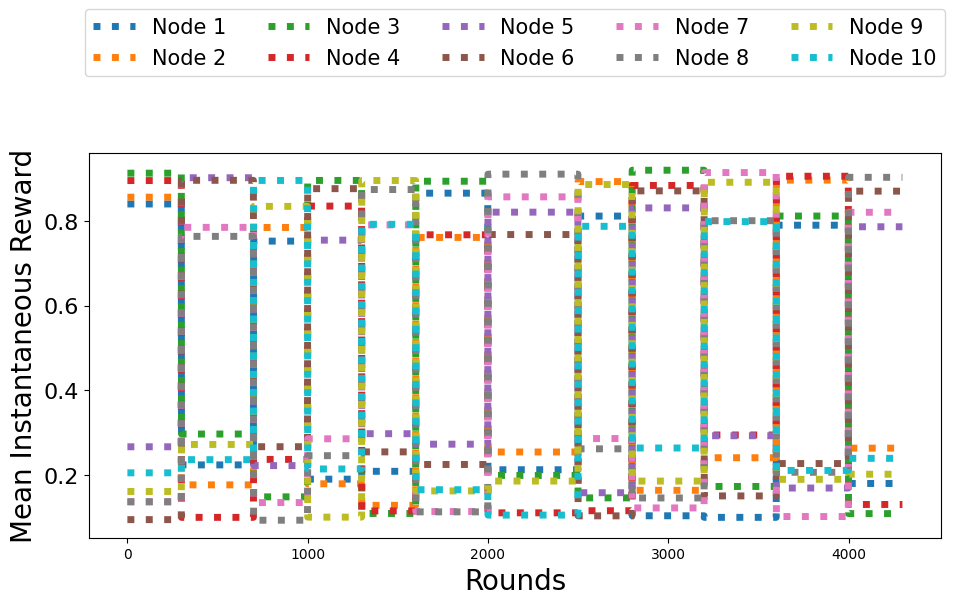

In [109]:
plot_array = np.zeros((nodes, rounds))
for i in range(0, len(change_points)):
    
    for j in range(rounds):
        if j == change_points[i]:
            if j == change_points[len(change_points)-1]:
                for k in range(nodes):
                    plot_array[k,j:rounds] = mean_b_gt[i,k]
            else:
                for k in range(nodes):
                    plot_array[k,j:change_points[i+1]] = mean_b_gt[i,k]

fig1, ax1 = plt.subplots(1,1, figsize=(11,5))
for arm in range(nodes):
#     expected_gain = BETA * mean_rewards[:, arm] 
    ax1.plot(plot_array[arm,:], label=f"Node {arm+1}", linestyle=':', linewidth=5)
#     print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = change_points
# plt.xticks(extraticks, fontsize=16) #, rotation=35

plt.yticks(fontsize=16)

ax1.set_xlabel('Rounds', fontsize=20)
ax1.set_ylabel(fr"Mean Instantaneous Reward", fontsize=20)

lgd = ax1.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.4), prop={'size': 15})

plt.show()
plt.close()

In [110]:
# s is the sparsity of the chosen action vector 
# nodes is the number of arms 

def initial_rounds_actions(nodes,s):

    initial_actions = np.zeros((nodes,nodes))
    initial_actions = initial_actions + np.eye(nodes)
    for i in range(nodes):
        if i <= s:
            for j in range(i):
                initial_actions[i,j] = 1
        elif i > s:
            temp = rand_binary_array(number_of_chosen_arms=s-1, n=i-1)
            temp1 = np.nonzero(temp)
            for j in range(temp1[0].shape[0]):
                temp2 = temp1[0][j]
                initial_actions[i,temp2] = 1
            
#     np.random.shuffle(initial_actions) #!
    needed_initial_matrix=initial_actions.T
    
    return needed_initial_matrix

## NDC-SEM Tuning

In [111]:
xis = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9] # [1e-9, 5e-9, 1e-8, 5e-8, 1e-7,
       # 5e-7, 1e-6, 5e-6, 5e-5, 1e-5]
gammas = [0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]


In [112]:
grid_size = len(list(itertools.product(xis, gammas)))
print(f"Size of param grid: {grid_size}")

Size of param grid: 35


In [113]:
estimated_time = grid_size * 400
print(f"Estimated total time: {estimated_time}s = {estimated_time/60}m = {estimated_time/3600}h")

Estimated total time: 14000s = 233.33333333333334m = 3.888888888888889h


In [114]:
total_start = time()
regrets = {}
all_regrets = {}

for (xi, gamma) in itertools.product(xis, gammas):
    print(f"Evaluating parameters {xi},{gamma}")
    start = time()
    
    np.random.seed(42)
    
    all_actions_taken = initial_rounds_actions(nodes=nodes, s=super_arm_sparsity)
    initial_rounds = nodes

    f_measure = np.zeros((1, rounds)) 
    collected_expected_rewards = np.zeros((1, rounds))
    collected_instantaneous_rewards = np.zeros((1, rounds))
    instantaneous_regret = np.zeros((1, rounds))
    expected_regret = np.zeros((1, rounds))

    num_plays_state = np.zeros((nodes, 1, rounds)) 
    emp_avg_reward_state = np.zeros((nodes, 1, rounds)) 
    UCB_state = np.ones((nodes, 1, rounds)) 
    
    ################ initial rounds ######################

    for i in range(0, initial_rounds):
        ch_p_ind = change_point_index(i)

        base_reward_i = np.transpose(np.asarray([B[:,i]]))
        x_i = np.transpose(np.asarray([all_actions_taken[:, i]]))  
        z_i = np.multiply(base_reward_i, x_i)

        y_i = np.matmul(C_gt, z_i)
        if i == 0:
            Y = y_i
        else:
            Y = np.concatenate((Y, y_i),axis=1)

        collected_expected_rewards[0,i] = overall_reward(x=x_i, b=mean_b_gt[ch_p_ind], A=w_gt) 
        collected_instantaneous_rewards[0,i] = overall_reward(x=x_i, b=base_reward_i, A=w_gt)

        expected_regret[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards[0,i]
        instantaneous_regret[0,i] = overall_reward(
            x=best_action_choice[ch_p_ind], b=base_reward_i, A=w_gt
        ) - collected_instantaneous_rewards[0, i]

        num_plays_state[:,:,i], emp_avg_reward_state[:,:,i], UCB_state[:,:,i] = UCB_func(
          t=i, x=all_actions_taken[:, i], num_plays_state=num_plays_state,
          inst_reward=B, xi=xi, s=s, gamma=gamma, Delay=Delay,
        )

#         print('collected reward of round ', i , ' is ', collected_expected_rewards[0,i])
        
    for i in range(initial_rounds, rounds):
        ch_p_ind = change_point_index(i)

        # Matrix which columns are z_t values up to current moment. 
        # Truncated matrix with up to (t - D) is calculated inside `graph_learning`
        Z_t = np.multiply(all_actions_taken, B[:, 0:all_actions_taken.shape[1]])

        if f_measure[0, i - 1] == 1:
            # Estimated adjacency matrix is good enough in previous round, no need to re-estimate it.
            f_measure[0, i] = f_measure[0, i - 1]
        else:     
            w_hat, f_measure[0, i], best_lambda = graph_learning(
                current_time=i, A_gt=w_gt, observ=Y, perturb=Z_t, 
                nodes=nodes, skiped=skiped, best_lambda=best_lambda, Delay=Delay,
            )
            if f_measure[0,i]>=0.9:
                skiped = 1
            elif f_measure[0,i]<0.9:
                skiped = 0

        base_reward_i = np.transpose(np.asarray([B[:,i]]))
        x_i = Best_action_func_new(A=w_hat, b=UCB_state[:,:,i - 1], s=super_arm_sparsity)
        all_actions_taken = np.concatenate((all_actions_taken, x_i), axis=1)

        z_i = np.multiply(base_reward_i, x_i)
        y_i = np.matmul(C_gt, z_i)
        Y = np.concatenate((Y, y_i), axis=1)

        collected_expected_rewards[0, i] = overall_reward(x=x_i, b=mean_b_gt[ch_p_ind], A=w_gt)
        collected_instantaneous_rewards[0, i] = overall_reward(x=x_i, b=base_reward_i, A=w_gt)
        expected_regret[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards[0, i]
        instantaneous_regret[0,i] = overall_reward(
            x=best_action_choice[ch_p_ind], b=base_reward_i, A=w_gt
        ) - collected_instantaneous_rewards[0,i]

        if expected_regret[0, i] < 0:
            raise ValueError()

        if i % 500 == 0:
            print(f"Round: {i}, t: {datetime.datetime.now()}\n")
#         print(f'collected reward round {i} is: ', collected_expected_rewards[0, i])

        num_plays_state[:,:,i], emp_avg_reward_state[:,:,i], UCB_state[:,:,i] = UCB_func(
          t=i, x=x_i, num_plays_state=num_plays_state,
          inst_reward=B, xi=xi, s=s, gamma=gamma, Delay=Delay,
        )
    print(f"Evaluating parameters {xi},{gamma}, took {time() - start:.2f}")
    
    regrets[(xi,gamma)] = np.sum(expected_regret)
    all_regrets[(xi, gamma)] = expected_regret

print(f"Total tuning took {time() - total_start:.2f} seconds")

Evaluating parameters 1e-05,0.93


/home/ls131416/.local/lib/python3.12/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/tmp/ls131416/login23-g-1_124632/ipykernel_125043/1449665698.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delayed_discounted_counts_state[k] += num_plays_state[k,:,j]*(gamma**(t-j))
/tmp/ls131416/login23-g-1_124632/ipykernel_125043/1449665698.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  emp_avg_reward_state_temp[k] = emp_avg_reward_state_temp[k] + inst_reward[k,j]*num_plays_state[k,:,j]

Round: 500, t: 2024-11-17 12:40:13.473980

Round: 1000, t: 2024-11-17 12:40:28.772636

Round: 1500, t: 2024-11-17 12:40:55.138696

Round: 2000, t: 2024-11-17 12:41:32.461277

Round: 2500, t: 2024-11-17 12:42:20.707943

Round: 3000, t: 2024-11-17 12:43:19.832917

Round: 3500, t: 2024-11-17 12:44:30.037999

Round: 4000, t: 2024-11-17 12:45:51.144986

Evaluating parameters 1e-05,0.93, took 407.24
Evaluating parameters 1e-05,0.94
Round: 500, t: 2024-11-17 12:47:00.123466

Round: 1000, t: 2024-11-17 12:47:15.466589

Round: 1500, t: 2024-11-17 12:47:41.787239

Round: 2000, t: 2024-11-17 12:48:19.228050

Round: 2500, t: 2024-11-17 12:49:07.580841

Round: 3000, t: 2024-11-17 12:50:06.818673

Round: 3500, t: 2024-11-17 12:51:16.740156

Round: 4000, t: 2024-11-17 12:52:37.437062

Evaluating parameters 1e-05,0.94, took 406.25
Evaluating parameters 1e-05,0.95
Round: 500, t: 2024-11-17 12:53:46.350924

Round: 1000, t: 2024-11-17 12:54:01.735559

Round: 1500, t: 2024-11-17 12:54:28.093022

Round: 20

## Save Regret Dict

In [115]:
filename_tot_regret = f"final_expected_regret_saving_d_{Delay}.csv"
dict_file_name = f'final_regret_d_{Delay}.pkl'

In [116]:
with open(dict_file_name, 'wb') as f:
    pickle.dump(regrets, f)

In [117]:
# tot_regrets_dict = {}
# l = 1
# for xi in xis:
#     for gamma in gammas:
#         tot_reg = regrets.get((xi, gamma))
#         tot_regrets_dict[f'({xi}, {gamma})'] = [tot_reg]
#         l += 1

In [118]:
# total_regrets_df = pd.DataFrame(tot_regrets_dict)

In [119]:
# total_regrets_df.to_csv(filename_tot_regret, sep=',')

### Load Data

In [120]:
# total_regrets_df = pd.read_csv(filename_tot_regret)

In [121]:
with open(dict_file_name, 'rb') as f:
    regrets = pickle.load(f)

## Hyper Parameter Sensitivity Plots

In [122]:
reg_map = np.zeros((len(xis), len(gammas)))
l1=0
l2=0
for xi in xis:
    for gamma in gammas:
        reg_map[l1][l2] = regrets.get((xi, gamma))
        l2 += 1
    l1 += 1
    l2 = 0


In [123]:
regrets

{(1e-05, 0.93): np.float64(5057.3698075329885),
 (1e-05, 0.94): np.float64(4864.636485134052),
 (1e-05, 0.95): np.float64(4392.303293209919),
 (1e-05, 0.96): np.float64(3960.9848741029464),
 (1e-05, 0.97): np.float64(3337.0935197781037),
 (1e-05, 0.98): np.float64(4623.61380089874),
 (1e-05, 0.99): np.float64(6287.943134090652),
 (1e-06, 0.93): np.float64(4700.363619197586),
 (1e-06, 0.94): np.float64(4368.701841363876),
 (1e-06, 0.95): np.float64(3911.53063617086),
 (1e-06, 0.96): np.float64(3791.05185280858),
 (1e-06, 0.97): np.float64(5095.236197887592),
 (1e-06, 0.98): np.float64(5233.797491286764),
 (1e-06, 0.99): np.float64(6747.840799919823),
 (1e-07, 0.93): np.float64(4534.303814586798),
 (1e-07, 0.94): np.float64(4033.3088069640717),
 (1e-07, 0.95): np.float64(3725.573983670727),
 (1e-07, 0.96): np.float64(3904.401221639062),
 (1e-07, 0.97): np.float64(4780.213934180826),
 (1e-07, 0.98): np.float64(5057.05912958334),
 (1e-07, 0.99): np.float64(6051.778348157362),
 (1e-08, 0.93

<>:8: SyntaxWarning: invalid escape sequence '\g'
<>:8: SyntaxWarning: invalid escape sequence '\g'
/tmp/ls131416/login23-g-1_124632/ipykernel_125043/3529633739.py:8: SyntaxWarning: invalid escape sequence '\g'
  xlabel=f'$\gamma$')


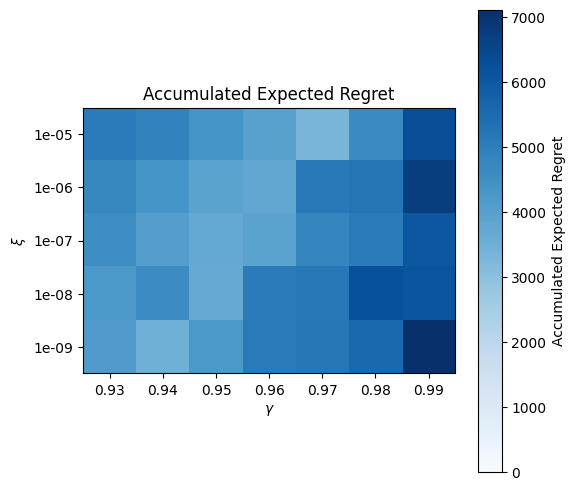

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(reg_map, vmin=0, cmap='Blues')
ax.set(yticks=np.arange(len(xis)),
       yticklabels=np.asarray(xis),
       xticks=np.arange(len(gammas)),
       xticklabels=np.asarray(gammas),
       ylabel=r'$\xi$',
       xlabel=f'$\gamma$')
ax.set_title("Accumulated Expected Regret")
# im = plt.imshow(reg_map, vmin=0, cmap='Blues')
cbar = plt.colorbar(im)
cbar.set_label("Accumulated Expected Regret")
# ax.xlabel(r'$\xi$')
#plt.xticks(np.asarray(xis))
# ax.ylabel(f'$\gamma$')
plt.show()
fig.savefig(f"accumulated_expected_regret_heatmap_d_{Delay}.jpg", format = 'jpg', dpi = 300)
plt.close()